In [1]:
import geopandas
import numpy
import numpy
import math
import shapely
import matplotlib.pyplot as plt
import datetime

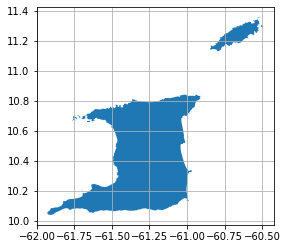

In [2]:
# Loading the geometries
fig, ax = plt.subplots()
ax.grid(True)

# 3:4 is canada 29:30 Brazil
polygons = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))#[4:5]
polygons = polygons[polygons.name =='United States of America']

# 3:4 is trinidad
polygons = geopandas.read_file('../data/caribbean.gpkg')[3:4]

#polygons = geopandas.read_file('../data/santa_barbara.gpkg')

polygons.plot(ax=ax)

geom_type = polygons.iloc[0].geometry.type
if  geom_type == 'Polygon':
    # We drop the last point because it is a repetition of the first point
    lon = polygons.iloc[0].geometry.exterior.xy[0]
    lat = polygons.iloc[0].geometry.exterior.xy[1]
elif geom_type == 'MultiPolygon':
    lon = []
    lat = []
    for p in list(polygons.iloc[0].geometry):
        lon += p.exterior.xy[0]
        lat += p.exterior.xy[1]

# Dirty trick to get rid of duplicate points
lat, lon = zip(*(set(zip(lat, lon))))

#lat, lon = zip(*list(dict.fromkeys(zip(lat, lon))))
#len(lat)
#lat

In [3]:
lon = numpy.array(lon)
lat = numpy.array(lat)

# We convert to ECEF vectors
x = numpy.cos(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
y = numpy.sin(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
z = numpy.sin(lat/360*math.pi*2)

# We create a nx3 matrix of the points 
nodes = numpy.array([x, y, z]).transpose()

n = len(x)
n

19255

# Approach 

In [4]:
# Naive
def make_gc(from_index, to_index):
    return numpy.cross(nodes[from_index], nodes[to_index])

def find_to_index(from_index):
    for to_index in node_indices:
        if from_index == to_index:
            continue
        edge = test_edge(from_index, to_index)
        if edge:
            return to_index
    return False

def find_first_from_index():
    for from_index in node_indices:
        to_index = find_to_index(from_index)
        if to_index:
            break
    return from_index

def test_edge(from_index, to_index):
    gc = numpy.cross(nodes[from_index], nodes[to_index])
    for node_index in node_indices:
        if node_index == to_index:
            continue
        elif node_index == from_index:
            continue
        elif numpy.array_equal(nodes[node_index ],nodes[to_index]):
            continue            
        else:            
            direction = numpy.dot(nodes[node_index], gc)            
            if direction < 0:
                return False
    return True        

In [5]:
# Recursive

def find_offender(from_index, to_index):
    gc = numpy.cross(nodes[from_index], nodes[to_index])
    for node_index in node_indices:
        if node_index == to_index:
            continue
        elif node_index == from_index:
            continue
        elif numpy.array_equal(nodes[node_index],nodes[to_index]):
            continue            
        else:            
            direction = numpy.dot(nodes[node_index], gc)            
            if direction < 0:
                return node_index
    return False

def find_to_index_rec(from_index):
    to_index = None
    to_candidate_index = 0
    while not to_index:
        offender = find_offender(from_index, to_candidate_index)
        if offender is False:
            return to_candidate_index
        else:
            to_candidate_index = offender

In [6]:
node_indices = list(range(nodes.shape[0]))
    
first_from_index = find_first_from_index()
from_index = first_from_index
to_index = find_to_index(from_index)
first_from_index
to_index

2462

In [ ]:
convex_nodes = []
while to_index != first_from_index:
    to_index = find_to_index_rec(from_index)   
    convex_nodes.append((from_index, to_index))
    from_index = to_index
convex_nodes

In [ ]:
convex_nodes = []
while to_index != first_from_index:
    to_index = find_to_index(from_index)   
    convex_nodes.append((from_index, to_index))
    from_index = to_index
convex_nodes

In [ ]:
convex_edges = []
for convex_node in convex_nodes:
    gc = make_gc(convex_node[0], convex_node[1])
    convex_edges.append(gc)

# Visualization

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.grid(True)

polygons.plot(ax=ax, color='b')

lines = []

for node in convex_nodes:
    from_node = (lon[node[0]], lat[node[0]])
    to_node = (lon[node[1]], lat[node[1]])
    lines.append(shapely.geometry.LineString([from_node, to_node]))

    
edges = geopandas.GeoDataFrame({'edges': lines}).set_geometry('edges')
edges.plot(ax=ax, color='r')

fig.savefig('hull.png')